# Decision Tree Classifier

```{tip}
It is recommended to use google colaboratory for running the notebook.
```

In [ ]:
# Extra libraries required

# Install ray tune
! pip install tune-sklearn ray[tune]

# Install shap
! pip install shap

Decision trees are non-parametric supervised algorithms which predicts the target variable by learning simple decision rules inferred from the data. They are widely known for their interpretability. They are highly reliable and can even perform under certain violations of assumptions. But they can be highly sensitive to data and can also be unstable.

In [ ]:
# Import necessary packages
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import plotly.express as px
import plotly.io as pio

In [3]:
# Set default plotly renderer
pio.renderers.default = "notebook_connected" # set it to "colab" for working in google colaboratory

In [4]:
# Load data into dataframe
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/uci/ospi/datasets/preprocessed_osi.csv')

## Preprocessing

In [5]:
y = df['Revenue']
X = df.drop('Revenue', axis=1)

In [6]:
# Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Since decision trees can not perform better with imbalanced target variable, it is necessary to oversample the minority class in the dataset.

In [ ]:
# Oversample the minority class in the target variable
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

## Model Training

In [8]:
# Declare the model
estimator = DecisionTreeClassifier()

# Declare cross-validation method
cv = StratifiedKFold()

# Declare the parameter grid to be searched
param_grid = dict(
    criterion = ['gini', 'entropy'],
    splitter = ['best', 'random'],
    max_depth = [20, 40, 60, None],
    min_samples_split = [2, 10, 40],
    max_features = ['auto', 'log2', None]
)

In [ ]:
# Import grid search model from tune sklearn
from tune_sklearn import TuneGridSearchCV

# Train the model
dtree_clf = TuneGridSearchCV(estimator=estimator, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=cv, use_gpu=True, verbose=2)
dtree_clf.fit(X_train, y_train)

In [10]:
# Get the best performing model
dtree_clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')

In [11]:
# Save and load the model if required
import joblib
joblib.dump(dtree_clf.best_estimator_, '/content/drive/MyDrive/Colab Notebooks/uci/ospi/models/dtree.pkl')
dtree_clf = joblib.load('/content/drive/MyDrive/Colab Notebooks/uci/ospi/models/dtree.pkl')

In [12]:
# Use model for prediction
y_pred = dtree_clf.predict(X_test)

## Model Evaluation

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.93      0.91      0.92      2594
        True       0.58      0.63      0.60       489

    accuracy                           0.87      3083
   macro avg       0.75      0.77      0.76      3083
weighted avg       0.87      0.87      0.87      3083



Model seems to be too weak for identifying the visitors who will transact. Decision tree classifier performed close to the support vector classifier and logistic regression. 

## Model Interpretation

Since decision trees use white-box models, it is easy to interpret them. The scikit-learn impleentation gives us the feature importances score for each independent variable used.

In [14]:
# Create a feature importance dataframe
feat_imp_data = zip(list(df.drop('Revenue', axis=1).columns), dtree_clf.feature_importances_)
feat_imp_df = pd.DataFrame(columns=['column', 'feature_importance'], data=feat_imp_data)

In [15]:
# Sort feature importance
feat_imp_df.sort_values('feature_importance', ascending=False, inplace=True)

In [16]:
fig = px.bar(feat_imp_df[:20], x='feature_importance', y='column', orientation='h')
fig.show()

Once again the feature page value came out to be the most important feature by a huge margin. The months of November and May also came out to be important as it was observed in the case of logistic regression. Surprisingly, this model thinks that number of product related pages visited by visitors is more important that the time spent by the visitors on those pages. The other most features features being bounce rate and number of informational pages visited by the visitors.

SHAP package contain the tree explainer which can be used for tree based algorithms such as decision trees.

In [17]:
# Import shap
import shap

In [18]:
# Comput shap values
explainer = shap.explainers.Tree(dtree_clf, X_train, feature_names=df.drop('Revenue', axis=1))
shap_values = explainer.shap_values(X_test)

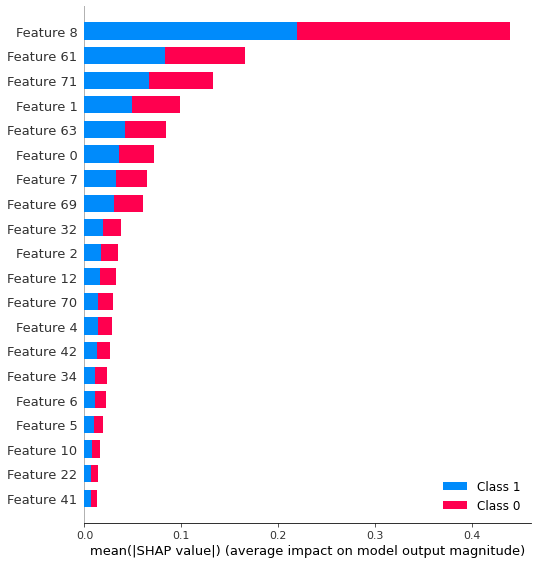

In [19]:
shap.summary_plot(shap_values)

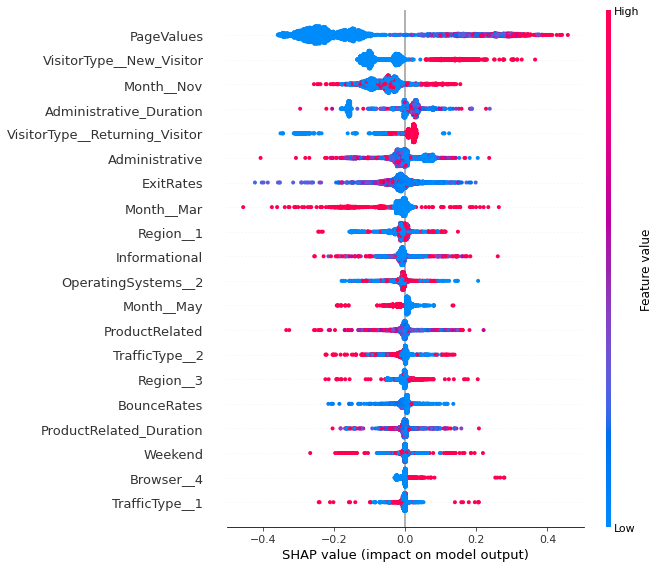

In [20]:
# Plot summary plot for class
shap.summary_plot(shap_values[1], X_test)

According to SHAP values, page values, month of November and month of May remains the most information feature. Low page values can't result into transactions. Month of may is not suitable for the business, while the month of November is the exact opposite. It is surprising to note that features related to administrative pages are more important than features related to product related pages. Also, the more the number of administrative pages a vistor visits, the less likely she is going to transact. It is also surprising that according to the model, the new visitors are more likely to transact.